# Branching DQN with Pendulum Continous - Solution
22.03.2022, Gruppe B

Reference:
https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py 


## Aufgaben

1. Bei der Diskretisierung des Action Space ist Min und Max fix codiert. Bitte die Werte aus dem Environment nehmem.
2. Deklariere LR und Gamma im Code
3. Definiere Aktivierungsfunktion (2x)
4. Definiere den Linear Input korrekt (2x)
5. Ergänze den zweiten Parameter für die Multiplikation mit dem state_dict
6. Welche Parameter müssen geändert werden, wenn die Gewichte vom Target Modell häufiger und stärker aktualisiert werden sollen

> Lösungen siehe mit TODO markierte Stellen


In [13]:
import collections
import os
import random
import numpy as np
import pandas as pd
from argparse import ArgumentParser

import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy.ndimage.filters import gaussian_filter1d


## Save plot and csv

In [15]:
def save(agent, rewards, envname):
    path = './runs/{}/'.format(envname)
    try:
        os.makedirs(path)
    except:
        pass
    torch.save(agent.q.state_dict(), os.path.join(path, 'model_state_dict'))
    # plot
    plt.cla()
    plt.plot(rewards, c = 'r', alpha = 0.3)
    plt.plot(gaussian_filter1d(rewards, sigma = 5), c = 'r', label = 'Rewards')
    plt.xlabel('Episodes')
    plt.ylabel('Cumulative reward')
    plt.title('Branching DDQN: {}'.format(envname))
    plt.savefig(os.path.join(path, 'reward.png'))
    # save csv
    pd.DataFrame(rewards, columns = ['Reward']).to_csv(os.path.join(path, 'rewards.csv'), index = False)

## ExperienceReplayMemory

In [3]:
class ExperienceReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []
        for b in batch:
            states.append(b[0])
            actions.append(b[1])
            rewards.append(b[2])
            next_states.append(b[3])
            dones.append(b[4])
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)

## StateDictHelper

In [4]:
class StateDictHelper():
    """Modify an existing state_dict by applying an arbitrary lambda expression or one of the given convince methods"""

    @staticmethod
    def apply(state_dict, func=lambda x: x):
        state_dict_new = collections.OrderedDict()
        for k in state_dict.keys():
            state_dict_new[k] = func(state_dict[k])
        return state_dict_new

    @staticmethod
    def mul(state_dict, value):
        return StateDictHelper.apply(state_dict, lambda x: x * value)

    @staticmethod
    def add(state_dict, value):
        return StateDictHelper.apply(state_dict, lambda x: x+value)

    @staticmethod
    def add_sd(state_dict, other_state_dict):
        state_dict_new = collections.OrderedDict()
        for k in state_dict.keys():
            state_dict_new[k] = state_dict[k] + other_state_dict[k]
        return state_dict_new

    @staticmethod
    def print(state_dict, title, break_after=2):
        count = 0
        print("# ----------------------------------------------------------------------------------")
        print("#", title)
        print("# ----------------------------------------------------------------------------------")
        for k in state_dict.keys():
            count = count + 1
            print(k, ":")
            for l in state_dict[k]:
                print("list shape =", l.shape, ", content = ", end="")
                if len(l.shape) == 0:
                    print(l, end="")
                else:
                    for e in l:
                        print(e, " : ", end="")
                print()
            if count >= break_after:
                break
        print()

## BranchingQNetwork

In [5]:
class BranchingQNetwork(nn.Module):                 # Agent
    def __init__(self,
                 obs,                               # observations
                 ac_dim, n):                        # continous actions auf n sections discretisiert
        super().__init__()
        self.ac_dim = ac_dim
        self.n = n
        self.model = nn.Sequential(
            nn.Linear(obs, 128),                    # Input = Observations
            # TODO:Aufgabe 3: Definiere Aktivierungsfunktion
            nn.ReLU(),
            nn.Linear(128,128),
            # TODO:Aufgabe 3: Definiere Aktivierungsfunktion
            nn.ReLU() )
        # TODO: Aufgabe 4: Definiere den Linear Input korrekt
        self.value_head = nn.Linear(128, 1)         # Value State
        # Advantage pro Action
        # TODO: Aufgabe 4: Definiere den Linear Input korrekt
        self.adv_heads = nn.ModuleList([nn.Linear(128, n) for i in range(ac_dim)])

    def forward(self, x):
        out = self.model(x)

        value = self.value_head(out)
        advs = torch.stack([l(out) for l in self.adv_heads], dim = 1)

        q_val = value.unsqueeze(2) + advs - advs.mean(2, keepdim = True )
        return q_val


    def update_model(self, other_model, tau=None):
        """Updates the model weigths, either 1:1 if tau is None or weighted with tau [0.0 - 1.0).

        The weighted update follows the following logic for model weights
        but is adapted for the model.state_dict parameters:
            new_target_weights = []
            for target, online in zip(self.model.get_weights(), other_model.model.get_weights()):
                target_ratio = (1.0 - self.tau) * target            # target_model (self)
                online_ratio = self.tau * online                    # online_model (other_model)
                mixed_weights = target_ratio + online_ratio
                new_target_weights.append(mixed_weights)
            self.model.set_weights(new_target_weights)
        """

        # standard update without weights
        if tau is None:
            self.load_state_dict( other_model.state_dict() )
            return

        # weighted update
        # TODO: Aufgabe 5: Ergänze den zweiten Parameter für die Multiplikation mit dem state_dict
        target_ratio = StateDictHelper.mul(self.state_dict(), 1-tau)
        online_ratio = StateDictHelper.mul(other_model.state_dict(), tau)
        new_target_sd = StateDictHelper.add_sd(target_ratio, online_ratio)
        self.load_state_dict( new_target_sd )

## AgentConfig and BranchingDQNAgent

In [20]:
class AgentConfig:
    def __init__(self,
                 
                 epsilon_start = 1.,
                 epsilon_final = 0.01,
                 epsilon_decay = 800,               # Orig=8000
                 gamma = 0.99,
                 lr = 1e-4,
                                                    # TODO: Aufgabe 6, Anpassung tau und freq
                 target_net_update_tau = 0.3,       # Orig=None, changed for weighted update to 0.1 [0.0. ... 1.0]
                 target_net_update_freq = 300,      # Orig=1000, changed for weighted update to 100
                 memory_size = 100000,
                 batch_size = 128,
                 learning_starts = 5000,
                 max_frames = 50000):            # 10000000
        self.epsilon_start = epsilon_start
        self.epsilon_final = epsilon_final
        self.epsilon_decay = epsilon_decay
        self.epsilon_by_frame = lambda i: self.epsilon_final + (self.epsilon_start - self.epsilon_final) * np.exp(-1. * i / self.epsilon_decay)
        
        # gamma and learining rate
        # TODO: Aufgabe 2: Deklariere Gamma und LR
        self.gamma = gamma
        self.lr = lr
        # update frequency, memory and batch size
        self.target_net_update_tau = target_net_update_tau
        self.target_net_update_freq = target_net_update_freq
        self.memory_size =memory_size
        self.batch_size =batch_size
        # initialize lr and frames
        self.learning_starts = learning_starts
        self.max_frames = max_frames


class BranchingDQNAgent(nn.Module):
    def __init__(self, obs, ac, n, config):
        super().__init__()
        # Model
        self.q = BranchingQNetwork(obs, ac,n )
        self.target = BranchingQNetwork(obs, ac,n )
        # self.target.load_state_dict(self.q.state_dict())
        self.target.update_model(self.q, tau=None)
        # Model update parameters
        self.target_net_update_tau = config.target_net_update_tau
        self.target_net_update_freq = config.target_net_update_freq
        self.update_counter = 0

    def get_action(self, x):
        with torch.no_grad():
            # a = self.q(x).max(1)[1]
            out = self.q(x).squeeze(0)                  # Beispiel
            action = torch.argmax(out, dim = 1)         # Tensor(4) [1,0,3,3] = 4 Aktionen, A1=Bin 1, A2=Bin 0, A3=Bin 3, A4=Bin 3
        return action.numpy()

    def update_policy(self, adam, memory, params):
        b_states, b_actions, b_rewards, b_next_states, b_masks = memory.sample(params.batch_size)
        states = torch.tensor(b_states).float()
        actions = torch.tensor(b_actions).long().reshape(states.shape[0],-1,1)
        rewards = torch.tensor(b_rewards).float().reshape(-1,1)
        next_states = torch.tensor(b_next_states).float()
        masks = torch.tensor(b_masks).float().reshape(-1,1)

        # Gather: Extraktion Q-Values für Aktionen (Index 2 = dritte Position = continous values)
        # - self.q(states)   = Tensor(128,4,6) wobei 4 Actions mit 6 continous values
        # - actions          = Tensor(128,4,1) wobei 4 Actions mit 6 discrete values (bin nummer 0..5), squeeze letzte dim weg nehmen
        # - current_q_values = Tensor(128,4)   wobei 4 Actions mit 6 continous values
        current_q_values = self.q(states).gather(2, actions).squeeze(-1)        # 128, 4

        with torch.no_grad():
            argmax = torch.argmax(self.q(next_states), dim = 2)
            # Target ist zuständig für nächsten State, Online zuständig für aktuellen State
            max_next_q_vals = self.target(next_states).gather(2, argmax.unsqueeze(2)).squeeze(-1)
            # Original
            # max_next_q_vals = max_next_q_vals.mean(1, keepdim = True)
            max_next_q_vals = max_next_q_vals.mean(1, keepdim = True).expand(-1,1) # max_next_q_vals.shape[1]) # Expand to 128,2 (Actions)

        expected_q_vals = rewards + max_next_q_vals*0.99*masks
        loss = F.mse_loss(expected_q_vals, current_q_values)
        adam.zero_grad()
        loss.backward()                             # Backward Step mit Gradienten Berechnen (Werte ändern)
        for p in self.q.parameters():               # Begrenzung Gradienten auf -1 .. 1
            p.grad.data.clamp_(-1.,1.)
        adam.step()

        self.update_counter += 1
        if self.update_counter % self.target_net_update_freq == 0:
            self.update_counter = 0
            # weighted update
            # self.target.load_state_dict(self.q.state_dict())
            self.target.update_model(self.q, self.target_net_update_tau)

## TensorEnv and BranchingTensorEnv

In [7]:
class TensorEnv(gym.Wrapper):
    def __init__(self, env_name):
        super().__init__(gym.make(env_name))

    def process(self, x):
        return torch.tensor(x).reshape(1,-1).float()

    def reset(self):
        return self.process(super().reset())

    def step(self, a):
        ns, r, done, infos = super().step(a)
        return self.process(ns), r, done, infos


class BranchingTensorEnv(TensorEnv):
    def __init__(self, env_name, n):
        super().__init__(env_name)
        self.n = n
        # TODO: Aufgabe 1: Min und Max aus Environment nehmem
        self.discretized = np.linspace(-2.0,2.0, self.n)    
        # self.discretized = np.linspace(max(self.action_space.low),max(self.action_space.high), self.n)    # bins=6, aus countinous action werden 6 bins gemacht

    def step(self, a):
        action = np.array([self.discretized[aa] for aa in a])
        return super().step(action)

## Training

--------------------------------
Observation Space:
Box(-8.0, 8.0, (3,), float32)
Action Space:
Box(-2.0, 2.0, (1,), float32)
--------------------------------


Rew: -125.974: 100%|██████████| 50000/50000 [02:53<00:00, 288.14it/s]


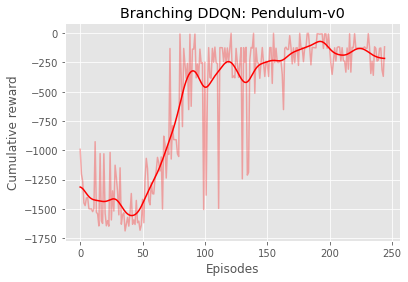

In [21]:
# Fix duplicate ddl error
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

envname = 'Pendulum-v0'

# Discretization of continous action space to linespace with n bins
bins = 8
env = BranchingTensorEnv(envname, bins)

print("--------------------------------")

print("Observation Space:")
print(env.observation_space)

print("Action Space:")
print(env.action_space)

print("--------------------------------")

# Initialize Agent (with Branching-Q-Network and Target-Branching-Q-Network), Memory and Optimizer
config = AgentConfig()
agent = BranchingDQNAgent(env.observation_space.shape[0], env.action_space.shape[0], bins, config)
memory = ExperienceReplayMemory(config.memory_size)
optimizer = optim.Adam(agent.q.parameters(), lr = config.lr)

s = env.reset()
ep_reward = 0.
recap = []

p_bar = tqdm(total = config.max_frames)
for frame in range(config.max_frames):

    epsilon = config.epsilon_by_frame(frame)

    if np.random.random() > epsilon:
        action = agent.get_action(s)
    else:
        action = np.random.randint(0, bins, size = env.action_space.shape[0])

    ns, r, done, infos = env.step(action)
    ep_reward += r

    if done:
        ns = env.reset()
        recap.append(ep_reward)
        p_bar.set_description('Rew: {:.3f}'.format(ep_reward))
        ep_reward = 0.

    # Umwandlung zu listen
    memory.push((s.reshape(-1).numpy().tolist(), action, r, ns.reshape(-1).numpy().tolist(), 0. if done else 1.))
    s = ns

    p_bar.update(1)

    if frame > config.learning_starts:
        agent.update_policy(optimizer, memory, config)

    if frame % 1000 == 0:
        save(agent, recap, envname)

p_bar.close()